In [1]:
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
#import pystan
#import arviz as az

sns.set(style="whitegrid")

depo_order = ["Tidal Channel", "Flood Tidal Delta", "Shoreface"]
RESULT_DIR = '../results/'

ModuleNotFoundError: No module named 'statsmodels'

# Interwell distances

In [2]:
idx = pd.IndexSlice

def injector_producer_unitarrows(locations, injectors, producers):
    out = pd.DataFrame(
        index=pd.MultiIndex.from_product([injectors, producers]),
        columns=["angle", "xn", "yn"],
    )
    for (i, p) in out.index:
        x1, y1 = locations.loc[i, ["SURFX ft", "SURFY ft"]]
        x2, y2 = locations.loc[p, ["SURFX ft", "SURFY ft"]]
        out.loc[idx[i, p], "angle"] = angle(x1, x2, y1, y2)
    out["xn"] = out["angle"].map(np.sin)
    out["yn"] = out["angle"].map(np.cos)
    return out

def arrows(gains_spatial, locations, arrow_factor=1):
    to_join = pd.DataFrame(
        index=gains_spatial.index.drop_duplicates(),
        columns=["angle", "dist", "xn", "yn"],
        dtype="float",
    )
    for (i, p) in to_join.index:
        x1, y1 = locations.loc[i, ["SURFX ft", "SURFY ft"]]
        x2, y2 = locations.loc[p, ["SURFX ft", "SURFY ft"]]
        to_join.loc[idx[i, p], "angle"] = angle(x1, x2, y1, y2)
        to_join.loc[idx[i, p], "dist"] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    to_join["xn"] = to_join["angle"].map(np.sin)
    to_join["yn"] = to_join["angle"].map(np.cos)
    new_gains_df = gains_spatial.join(to_join)
    for axis in ["x", "y"]:
        new_gains_df[axis + "_arrow"] = (
            new_gains_df[axis + "n"] * new_gains_df["Gain"] * arrow_factor
        )
    return new_gains_df.drop(columns=["xn", "yn"])

def angle(x1, x2, y1, y2):
    x_diff = x2 - x1
    y_diff = y2 - y1
    return np.arctan2(x_diff, y_diff)

# gains_df = arrows(gains_spatial, locations, arrow_factor=1)

In [3]:
!head ../data/well_locations_Senlac.csv

,NAD83,NAD83
Well ID,X locn,Y locn
P01,584147.1,5798516.2
P02,584645.2,5798524.7
P03,584883.8,5798523.3
P04,585365,5798128.8
P05,585466,5797729.01
P06,584173.5,5797729
P07,584657.1,5797874.1
P08,583866.9,5797679.3


In [4]:
locations = pd.read_csv(
    "../data/well_locations_Senlac.csv",
    skiprows=[0,1],
    names=["Well ID", "SURFX ft", "SURFY ft"],
    index_col=0,
)
locations["Type"] = locations.index.map(
    lambda x: "Producer" if x[0] == "P" else "Injector"
)

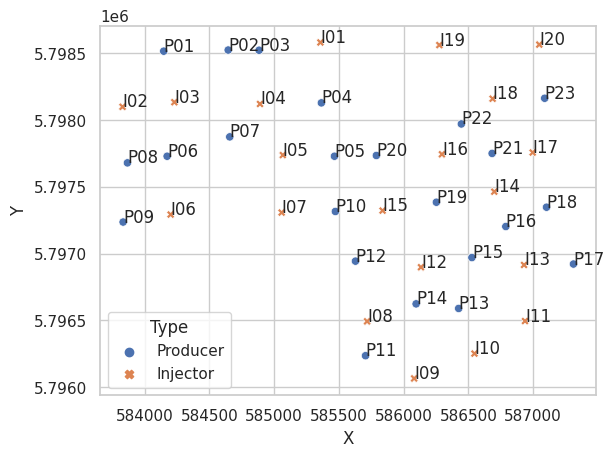

In [5]:
g = sns.scatterplot(
    data=locations, x="SURFX ft", y="SURFY ft", style="Type", hue="Type"
)
g.set(xlabel="X", ylabel="Y")
for i in range(locations.shape[0]):
    g.annotate(
        locations.index[i],
        (locations["SURFX ft"].iloc[i], locations["SURFY ft"].iloc[i]),
    )

In [6]:
# connectivity, Jerry's distances
excel = pd.ExcelFile("../results_Jerry/Lambda vs IWD all wells Frank.xlsx")
df = pd.concat(
    [
        pd.read_excel(excel, sheet_name=s)
        .dropna(how="all")
        .assign(
            Deposition=s.replace(" OK", ""),
            Injector=lambda x: x.Injector.fillna(method="ffill"),
        )
        .rename(columns={"Lambda": "Gain"})
        for s in excel.sheet_names
    ]
).dropna("columns")
producers = df.Producer.unique()
injectors = df.Injector.unique()
df = df.set_index(["Injector", "Producer"])

# distances from locations
df = arrows(df, locations)

# azimuths from Jerry
excel = pd.ExcelFile("../results_Jerry/Lambda and Azimuth for Frank.xlsx")
df2 = pd.concat(
    [
        pd.read_excel(excel, sheet_name=s)
        .dropna(how="all")
        .assign(
            Deposition=s.replace(" OK", ""),
            Producer=lambda x: x.Producer.fillna(method="ffill"),
        )
        .drop(columns=["Unnamed: 4"])
        for s in excel.sheet_names
    ]
).dropna("columns")
df2["Azimuth bin"] = pd.cut(df2["Azimuth mod 180"], range(15, 196, 30),).fillna(
    pd.Interval(165, 195, closed="right")
)  # labels=['<45', '45-90', '90-135','>135'])
df2["Fraction of wells"] = df2["Connectivity"].apply(lambda x: 1 if x > 0.05 else 0)
print(df.shape)
df = df.merge(
    df2[
        ["Injector", "Producer", "Azimuth mod 180", "Azimuth bin", "Fraction of wells"]
    ],
    on=["Injector", "Producer"],
    how="left",
)  # .dropna('columns', how='all')
df.drop(columns=['Azimuth bin']).to_feather('../data/gain_distance.feather')
df

mpi_data = pd.read_parquet(RESULT_DIR + "Lambda_MPI.parquet")
crm_gains_new = pd.read_csv(RESULT_DIR + "Senlac_CRM_jax_gains.csv", index_col=0)

df = df.merge(
    -mpi_data.rename_axis(index='Producer', columns='Injector').stack().rename('Gain_MPI'),
    left_on=['Producer','Injector'], right_index=True,
).merge(
    crm_gains_new.rename_axis(index='Producer', columns='Injector').stack().rename('Gain_CRM_Frank'),
    left_on=['Producer','Injector'], right_index=True,
)

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[Text(0.5, 0, 'Distance from spreadsheet'),
 Text(0, 0.5, 'Distance from locations')]

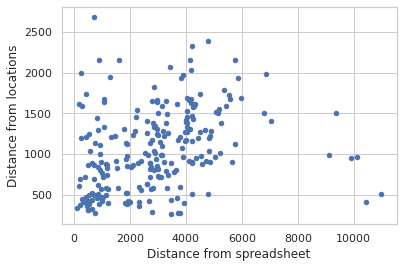

In [8]:
df.plot.scatter(x="Interwell Distance (m)", y="dist")
plt.gca().set(xlabel="Distance from spreadsheet", ylabel="Distance from locations")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[Text(0.5, 0, 'Angle from spreadsheet'), Text(0, 0.5, 'Angle from locations')]

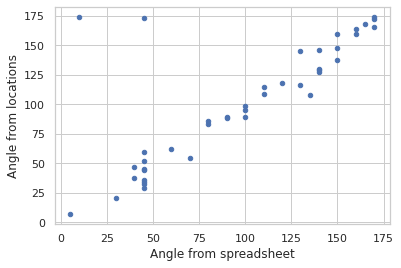

In [9]:
df.assign(angle2=lambda x: np.mod(x.angle * 180 / np.pi + 360, 180)).plot.scatter(
    x="Azimuth mod 180", y="angle2"
)
plt.gca().set(xlabel="Angle from spreadsheet", ylabel="Angle from locations")

In [10]:
df.loc[df["dist"].idxmax()]

Injector                                I20
Producer                                P11
Gain                               0.120044
Tau                              655.740699
Interwell Distance (m)               703.65
Deposition                Flood Tidal Delta
angle                             -2.619251
dist                            2689.657341
x_arrow                           -0.059891
y_arrow                           -0.104037
Azimuth mod 180                         NaN
Azimuth bin                             NaN
Fraction of wells                       NaN
Gain_MPI                           0.044975
Gain_CRM_Frank                          0.0
Name: 178, dtype: object

In [11]:
df.loc[df["Interwell Distance (m)"].idxmax()]

Injector                         I16
Producer                         P20
Gain                        0.023583
Tau                       313.936785
Interwell Distance (m)      10986.18
Deposition                 Shoreface
angle                      -1.588176
dist                      506.376471
x_arrow                    -0.023579
y_arrow                     -0.00041
Azimuth mod 180                  NaN
Azimuth bin                      NaN
Fraction of wells                NaN
Gain_MPI                    0.059425
Gain_CRM_Frank              0.099765
Name: 219, dtype: object

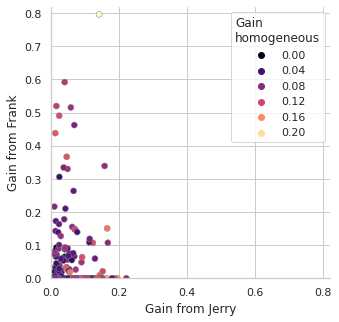

In [9]:
fig, ax = plt.subplots(figsize=(5,5))
g = sns.scatterplot(
    data=df.rename(columns={"Gain_MPI":"Gain\nhomogeneous"}), 
    x="Gain", y="Gain_CRM_Frank", hue='Gain\nhomogeneous', palette='magma', edgecolor='gray',ax=ax
)
g.set(xlabel='Gain from Jerry', ylabel='Gain from Frank', xlim=(0,0.82), ylim=(0,0.82))
sns.despine()

,Interwell distance,Connectivity (MPI),Connectivity (Jerry),Connectivity (Frank)
Interwell distance,1.000000,0.433844,0.073660,0.086211
Connectivity (MPI),0.433844,1.000000,0.145656,0.111743
Connectivity (Jerry),0.073660,0.145656,1.000000,0.005081
Connectivity (Frank),0.086211,0.111743,0.005081,1.000000


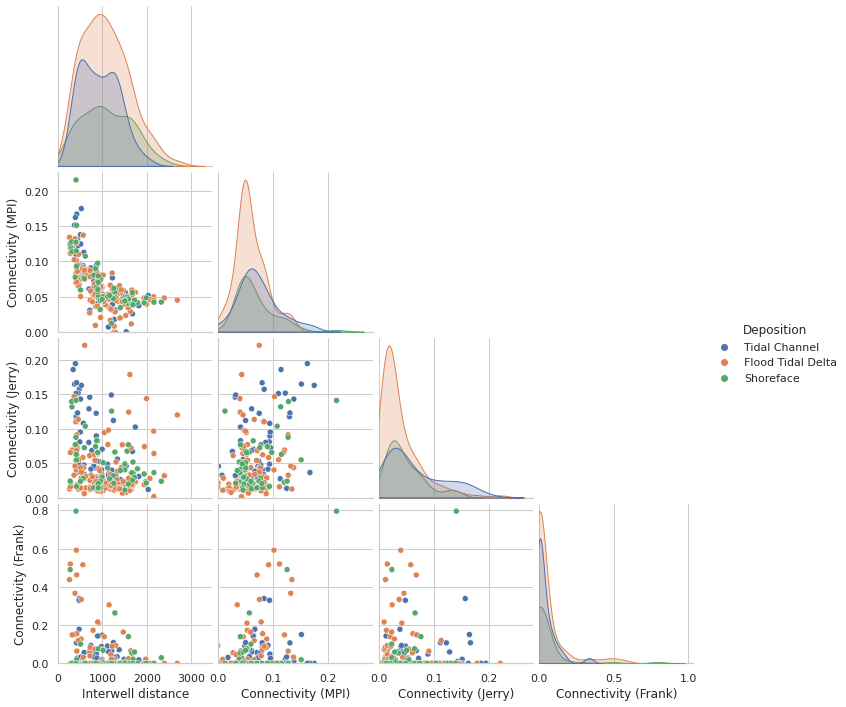

In [10]:
data = df[
    ['dist', 'Gain_MPI', 'Gain','Gain_CRM_Frank', 'Deposition']
    ].rename(
    columns={'Gain':'Connectivity (Jerry)','Gain_CRM_Frank':'Connectivity (Frank)', 'Gain_MPI':'Connectivity (MPI)','dist':'Interwell distance'}
)

g = sns.pairplot(
    data, 
    hue='Deposition', 
    corner=True
)
g.set(xlim=(0,None), ylim=(0,None))
g.savefig('figures/gain_comparison.png')

data.corr()**2

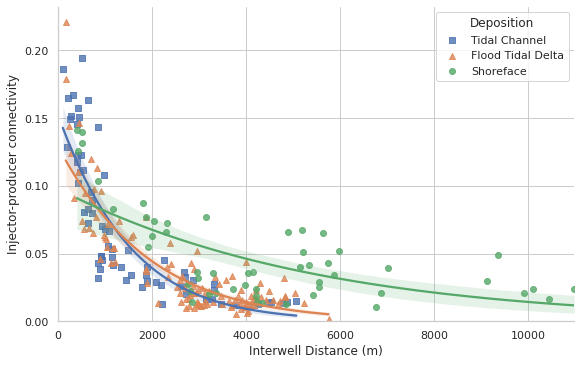

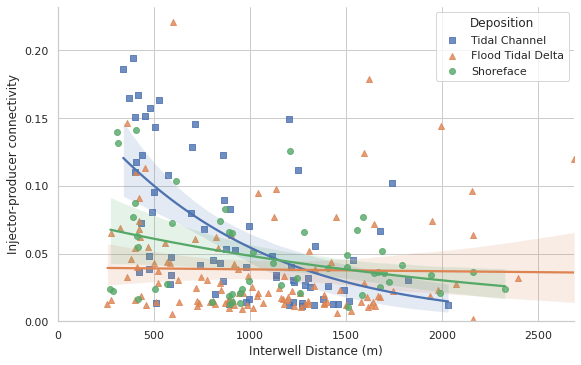

In [11]:
# plotting simplicity

facet = sns.lmplot(
    data=df,
    x="Interwell Distance (m)",
    y="Gain",
    hue="Deposition",
    hue_order=depo_order,
    markers=["s", "^", "o"],
    logistic=True,
    legend_out=False,
    aspect=1.6,
)
facet.set(xlim=(0, None), ylabel="Injector-producer connectivity", ylim=(0, None))
# facet.savefig('figures/per-depo-connectivity.png', dpi=300, bbox_inches='tight')

facet = sns.lmplot(
    data=df,
    x="dist",
    y="Gain",
    hue="Deposition",
    hue_order=depo_order,
    markers=["s", "^", "o"],
    logistic=True,
    legend_out=False,
    aspect=1.6,
)
facet.set(xlabel='Interwell Distance (m)', xlim=(0, None), ylabel="Injector-producer connectivity", ylim=(0, None))
facet.savefig("figures/per-depo-connectivity.png", dpi=300, bbox_inches="tight")

# Azimuth

[(0.0, 1.025), Text(0, 0.5, 'Fraction of wells connected')]

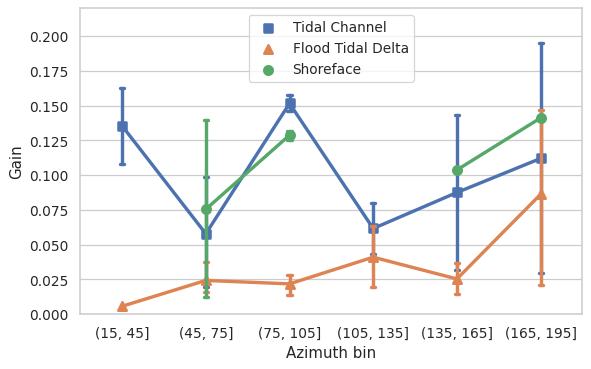

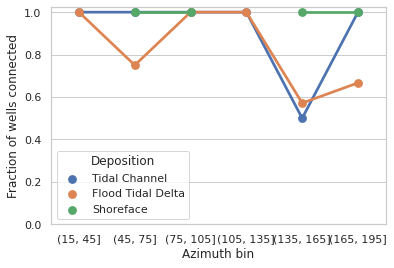

In [13]:
fig, ax = plt.subplots(figsize=(4.5 * 1.6, 4.5), dpi=90)
g = sns.pointplot(
    x="Azimuth bin",
    y="Gain",
    hue="Deposition",
    data=df,
    capsize=0.05,
    ax=ax,
    markers=["s", "^", "o"],
    hue_order=depo_order,
)
g.set(ylim=(0, 0.22))
g.legend(loc="upper center")
fig.savefig("figures/azimuth-depo-connectivity.png", dpi=400, bbox_inches="tight")

plt.figure()
g2 = sns.pointplot(
    x="Azimuth bin",
    y="Fraction of wells",
    hue="Deposition",
    data=df,
    capsize=0.1,
    ci=None,
)
g2.set(ylim=(0, None), ylabel="Fraction of wells connected")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Gain   No. Observations:                  239
Model:                            GLM   Df Residuals:                      237
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -33.551
Date:                Mon, 15 Nov 2021   Deviance:                       3.5524
Time:                        23:47:13   Pearson chi2:                     5.42
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -2

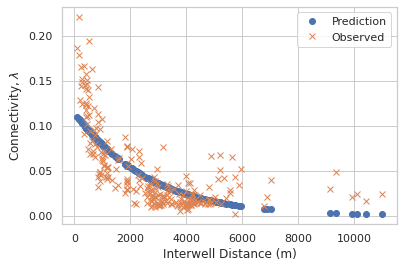

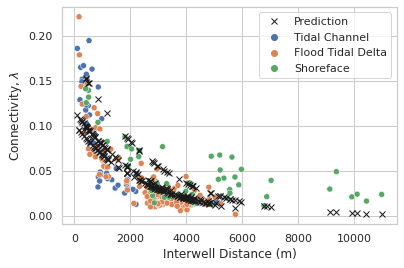

In [14]:
# Statsmodel for test

# Just distance
data = sm.add_constant(df[["Interwell Distance (m)"]])
y = df["Gain"]
regression = sm.GLM(y, data, family=sm.families.Binomial()).fit()
print(regression.summary())
plt.figure()
plt.plot(
    df["Interwell Distance (m)"], regression.predict(data), "o", label="Prediction"
)
plt.plot(df["Interwell Distance (m)"], y, "x", label="Observed")
plt.gca().set(xlabel="Interwell Distance (m)", ylabel="Connectivity, $\lambda$")
plt.legend()

# Distance and deposition
data = pd.concat(
    [
        df["Interwell Distance (m)"],
        pd.get_dummies(df["Deposition"], prefix="Deposition"),
    ],
    axis=1,
)
# data = sm.add_constant(data)
y = df["Gain"]
regression = sm.GLM(y, data, family=sm.families.Binomial()).fit()
print(regression.summary())
plt.figure()
plt.plot(
    df["Interwell Distance (m)"], regression.predict(data), "kx", label="Prediction"
)
sns.scatterplot(data=df, x="Interwell Distance (m)", y="Gain", hue="Deposition")
plt.gca().set(xlabel="Interwell Distance (m)", ylabel="Connectivity, $\lambda$")
plt.legend()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Gain   No. Observations:                  239
Model:                            GLM   Df Residuals:                      237
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -35.524
Date:                Wed, 31 Mar 2021   Deviance:                       7.4992
Time:                        00:43:14   Pearson chi2:                     8.88
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4454      0.668     -3.662      0.0

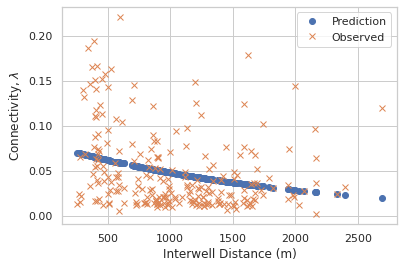

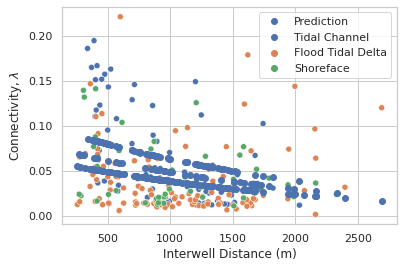

In [16]:
# Statsmodel for test

# Just distance
data = sm.add_constant(df[["dist"]])
y = df["Gain"]
regression = sm.GLM(y, data, family=sm.families.Binomial()).fit()
print(regression.summary())
plt.figure()
plt.plot(
    df["dist"], regression.predict(data), "o", label="Prediction"
)
plt.plot(df["dist"], y, "x", label="Observed")
plt.gca().set(xlabel="Interwell Distance (m)", ylabel="Connectivity, $\lambda$")
plt.legend()

# Distance and deposition
data = pd.concat(
    [
        df["dist"],
        pd.get_dummies(df["Deposition"], prefix="Deposition"),
    ],
    axis=1,
)
# data = sm.add_constant(data)
y = df["Gain"]
regression = sm.GLM(y, data, family=sm.families.Binomial()).fit()
print(regression.summary())
plt.figure()
plt.plot(
    df["dist"], regression.predict(data), "o", label="Prediction"
)
sns.scatterplot(data=df, x="dist", y="Gain", hue="Deposition")
plt.gca().set(xlabel="Interwell Distance (m)", ylabel="Connectivity, $\lambda$")
plt.legend()

In [36]:
import pymc3 as pm

with pm.Model() as p_model:
    mu = pm.Normal('beta', mu=1, sd=2)
    gamma = pm.Normal('gamma', mu=0.5, sd=2)
    model_err = pm.Halfnormal('model_err', sd=2)
    y_est = pm.math.invlogit(mu * df['dist'])
    y_like = pm.Beta('y_like', mu=y_est, sd=model_err, observed=df['Gain'])

ModuleNotFoundError: No module named 'pymc3'

In [26]:
model_code = """
data {
    int<lower=1> N;
    int<lower=1> K;
    vector<lower=0,upper=1>[N] gain;
    vector<lower=0>[N] x;
    int<lower=1> Az[N];
}
parameters {
    vector[K] beta;
    vector[K] gamma;
}
transformed parameters {
    vector<lower=0, upper=1>[N] mu;
    vector<lower=0>[N] phi;
    vector<lower=0>[N] A;
    vector<lower=0>[N] B;
    
    for (i in 1:N) {
        mu[i] = inv_logit(x[i] * beta[Az[i]]);
        phi[i] = exp(x[i] * gamma[Az[i]]);
    }
    
    A = mu .* phi;
    B = (1.0 - mu) .* phi;
}
model {
    gain ~ beta(A, B);
}
"""
"""
generated quantities{
    vector[N] log_lik;
    vector[N] log_lik_rep;
    vector<lower=0,upper=1>[N] y_rep;
    real total_log_lik;
    real total_log_lik_rep;
    int<lower=0, upper=1> p_omni;
    
    for (i in 1:N) {
        log_lik[i] = beta_lpdf(gain[n] | A[i], B[i]);
        y_rep[i] = beta_rng(A[i], B[i]);
        log_lik_rep[i] = beta_lpdf(y_rep[i] | A[i], B[i]);
    }
    
    total_log_lik = sum(log_lik);
    total_log_lik_rep = sum(log_lik_rep);
    p_omni = total_log_lik_rep > total_log_lik;
}
"""
%time stan_model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_973a6ea14cd236fb48ed06b373314152 NOW.


CPU times: user 1.18 s, sys: 44.1 ms, total: 1.23 s
Wall time: 47.9 s


In [27]:
df_filtered = df.dropna()
data = {
    "N": len(df_filtered.Gain),
    "K": df_filtered["Azimuth bin"].cat.codes.max() + 1,
    "gain": df_filtered.Gain,
    "x": df_filtered["Interwell Distance (m)"],
    "Az": df_filtered["Azimuth bin"].cat.codes + 1,
}
fit = stan_model.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=99)

RuntimeError: Initialization failed.

In [30]:
stan_beta ="""
data {
  int<lower=1> N;
  int<lower=1> K;
  int<lower=1> J;
  vector<lower=0,upper=1>[N] y;
  matrix[N,K] X;
  matrix[N,J] Z;
}

parameters {
  vector[K] beta;
  vector[J] gamma;
}

transformed parameters{
  vector<lower=0,upper=1>[N] mu;    // transformed linear predictor for mean of beta distribution
  vector<lower=0>[N] phi;           // transformed linear predictor for precision of beta distribution
  vector<lower=0>[N] A;             // parameter for beta distn
  vector<lower=0>[N] B;             // parameter for beta distn

  for (i in 1:N) {
    mu[i]  = inv_logit(X[i,] * beta);   
    phi[i] = exp(Z[i,] * gamma);
  }

  A = mu .* phi;
  B = (1.0 - mu) .* phi;
}

model {
  // priors

  // likelihood
  y ~ beta(A, B);
}

generated quantities{
  vector[N] log_lik;
  vector[N] log_lik_rep;
  vector<lower=0,upper=1>[N] y_rep;
  real total_log_lik;
  real total_log_lik_rep;
  
  int<lower=0, upper=1> p_omni;

  for (n in 1:N) {
    log_lik[n] = beta_lpdf(y[n] | A[n], B[n]);
    y_rep[n] = beta_rng(A[n], B[n]);
    log_lik_rep[n] = beta_lpdf(y_rep[n] | A[n], B[n]);
  }

  total_log_lik = sum(log_lik);
  total_log_lik_rep = sum(log_lik_rep);

  p_omni = (total_log_lik_rep > total_log_lik);
}
"""
%time stan_model_daltonhance = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_973a6ea14cd236fb48ed06b373314152 NOW.


CPU times: user 960 ms, sys: 59.9 ms, total: 1.02 s
Wall time: 47.8 s


In [33]:
df_filtered = df.dropna()
data = {
    "N": len(df_filtered.Gain),
    "K": 1, 
    "J":1,
    "y": df_filtered.Gain,
    "X": df_filtered["Interwell Distance (m)"],
    "Z": df_filtered["Azimuth bin"].cat.codes + 1,
}
fit = stan_model_daltonhance.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=99)

RuntimeError: Exception: variable does not exist; processing stage=data initialization; variable name=gain; base type=vector_d  (in 'unknown file name' at line 5)
